# "Galfitting" with lenstronomy
An example of using **lenstronomy** without imposing a lensing deflector is the inference of galaxy structural parameters through the fitting of a parameterized surface brightness model (or many thereof).

Specific software packages and algorithm that are designed to perform these tasks may well be faster and more optimized. However, we want to demonstrate the flexibility of **lenstronomy**. Matching the structural properties of lensing and source galaxy is an integral part of lens modelling. Where speed may not be the primary requirement, **lenstronomy** may provide an alternative in python.



In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## create mock image as a superposition of different profiles
In the example below, we generate a galaxy image with a two component Sersic profile at the same center and a compagnion Hernquist light distribution. The data quality is comparable with wide field surveys.

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log10


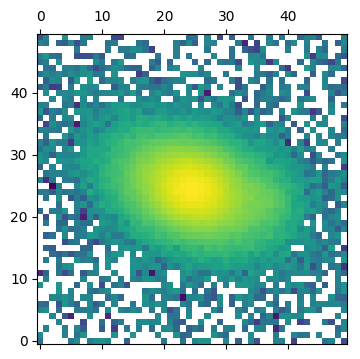

In [2]:
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()

# data specifics
sigma_bkg = .05  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 50  # cutout pixel size
deltaPix = 0.3  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.8  # full width half max of PSF

data_class = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
# PSF specification
psf_class = SimAPI.psf_configure(psf_type='GAUSSIAN', fwhm=fwhm, kernelsize=31, deltaPix=deltaPix, truncate=6, kernel=None)

# create a model with three Sersic profiles
# all the models are part of 'lens_light_model_list', meaning that their surface brightness profile are not lensed
lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'HERNQUIST']
from lenstronomy.LightModel.light_model import LightModel
lightModel = LightModel(lens_light_model_list)

kwargs_1 = {'amp': 10, 'R_sersic': .5, 'n_sersic': 3, 'e1': 0.1, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_2 = {'amp': 10, 'R_sersic': 1.5, 'n_sersic': 1, 'e1': 0.2, 'e2': -0.2, 'center_x': 0, 'center_y': 0}
kwargs_3 = {'amp': 10, 'Rs': 0.3, 'center_x': 3.5, 'center_y': -0.5}
kwargs_light = [kwargs_1, kwargs_2, kwargs_3]

kwargs_numerics = {'subgrid_res': 2}
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics)
image_sim = SimAPI.simulate(imageModel, kwargs_lens_light=kwargs_light)

data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()


In [3]:

kwargs_model = {'lens_light_model_list': lens_light_model_list}
kwargs_constraints = {'joint_center_lens_light': False}
kwargs_numerics_galfit = {'subgrid_res': 2}
kwargs_likelihood = {'check_bounds': True}

kwargs_data = data_class.constructor_kwargs()
kwargs_psf = psf_class.constructor_kwargs()
image_band = [kwargs_data, kwargs_psf, kwargs_numerics_galfit]
multi_band_list = [image_band]



In [4]:

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# first Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': .1, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.2, 'e1_sigma': 0.1, 'e2_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# second Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': .5, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.2, 'e1_sigma': 0.1, 'e2_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# Hernquist component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'Rs': 0.7, 'center_x': 3., 'center_y': 0.})
kwargs_lens_light_sigma.append({'Rs_sigma': 0.3, 'center_x_sigma': 0.5, 'center_y_sigma': 0.5})
kwargs_lower_lens_light.append({'Rs': 0.01, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
        {'fitting_routine': 'PSO', 'mpi': False, 'sigma_scale': 1., 'n_particles': 200,
         'n_iterations': 200}]

lens_result, source_result, lens_light_result, ps_result, cosmo_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)



Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
converged after 176 iterations!
best fit found:  -1186.2416181513474 [ 3.01712100e-01  5.98439406e+00  1.68961297e-01  8.72876688e-02
 -4.56884986e-04 -1.77897582e-02  1.44545233e+00  1.06485931e+00
  1.89344824e-01 -1.98894412e-01  6.00774228e-03  4.53129395e-03
  2.78790235e-01  3.44064163e+00 -5.07168519e-01]
(-0.9551059727466565, 'reduced X^2 of best position')
(-1186.2416181513474, 'logL')
(2484, 'effective number of data points')
([], 'lens result')
([], 'source result')
([{'e1': 0.16896129716825264, 'n_sersic': 5.9843940602281265, 'center_x': -0.0004568849863775837, 'center_y': -0.01778975817812575, 'amp': 1, 'R_sersic': 0.3017120999315053, 'e2': 0.08728766883426259}, {'e1': 0.18934482429485985, 'n_sersic': 1.0648593128800576, 'center_x': 0.006007742284321549, 'center_y': 0.004531293950397416, 'amp': 1, 'R_sersic': 1.4454523303887905, 'e2': -0.19889441214653922}, {'amp': 1, 'center_x': 3.44064162968

('reduced chi^2 = ', 0.9280546940785873)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:245: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


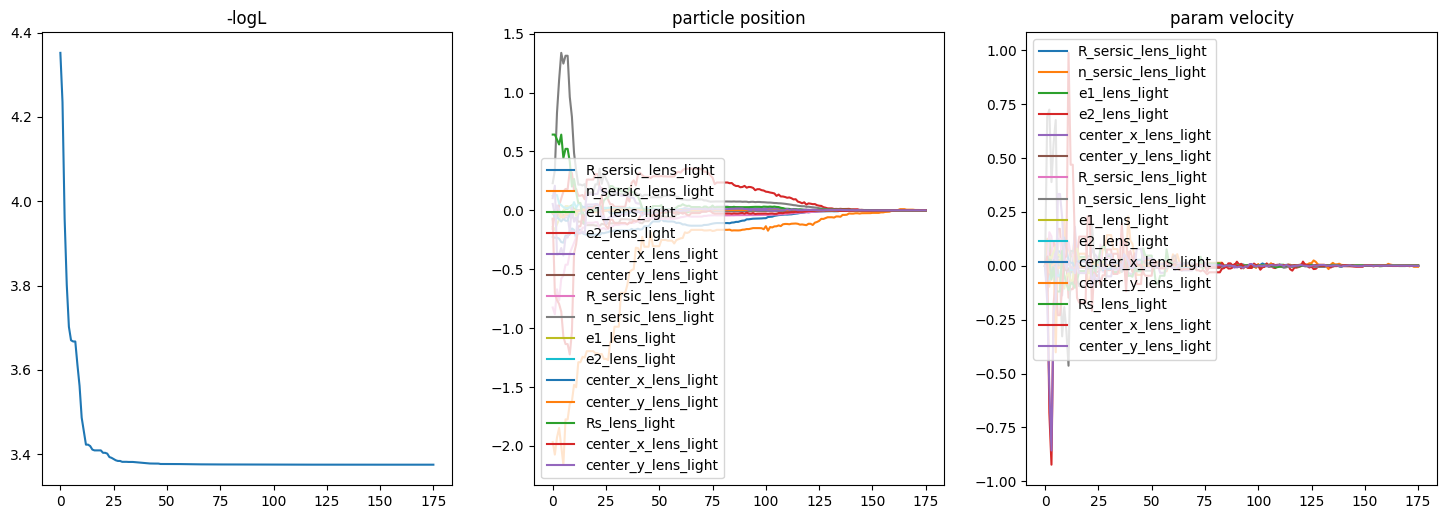

<Figure size 600x400 with 0 Axes>

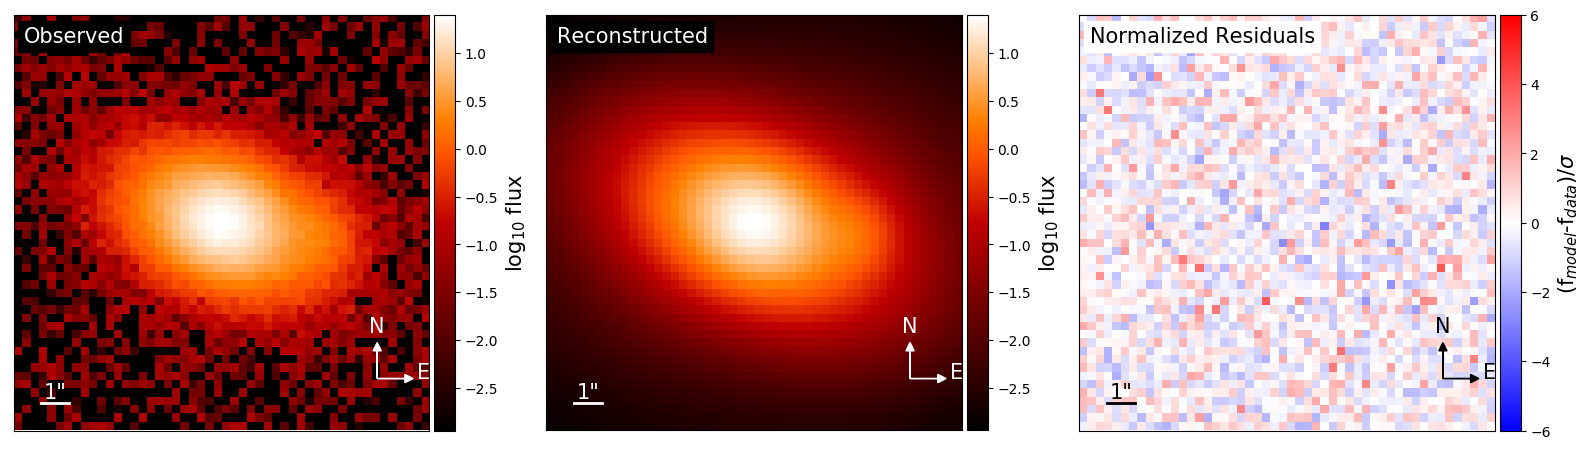

/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:558: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


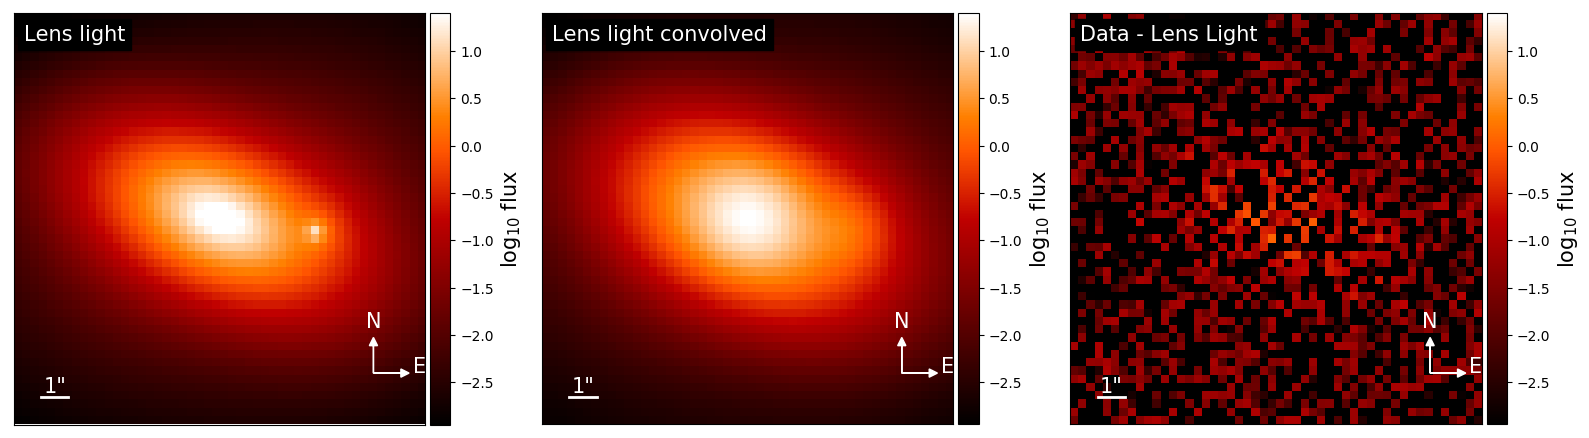

[{'e1': 0.16896129716825264, 'n_sersic': 5.9843940602281265, 'center_x': -0.0004568849863775837, 'center_y': -0.01778975817812575, 'amp': 20.742683728806924, 'R_sersic': 0.3017120999315053, 'e2': 0.08728766883426259}, {'e1': 0.18934482429485985, 'n_sersic': 1.0648593128800576, 'center_x': 0.006007742284321549, 'center_y': 0.004531293950397416, 'amp': 10.934599420615996, 'R_sersic': 1.4454523303887905, 'e2': -0.19889441214653922}, {'amp': 11.784178679685482, 'center_x': 3.440641629689589, 'center_y': -0.5071685194555298, 'Rs': 0.2787902354400897}]


In [5]:
from lenstronomy.Plots.output_plots import LensModelPlot
import lenstronomy.Plots.output_plots as out_plot

lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)

for i in range(len(chain_list)):
        if len(param_list[i]) > 0:
            f, axes = out_plot.plot_chain(chain_list[i], param_list[i])

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0])
lensPlot.model_plot(ax=axes[1])
lensPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0], text='Lens light', lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1], text='Lens light convolved', lens_light_add=True)
lensPlot.subtract_from_data_plot(ax=axes[2], text='Data - Lens Light', lens_light_add=True)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print lens_light_result